First, we load the needed packages:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

plt.style.use("ggplot")

pd.set_option('display.max_columns', None)

Next, we fit the new data to see how the algorithm performs in this case. The data has changed in a couple of different ways: 1.) We now do not randomly split the training and test set anymore, as this can lead to data leakage, in particular for the cyberattacks. 2.) We observe that there are often large periods of data missing for cyberattacks. Therefore, we define a new feature that will act as a warning flag in this case. Apart from that, the missing data is still filled in with the last measured previous value. 3.) We have new features accounting for the zeek log data.

In [2]:
path_train="../../data/Rockwell_Flow_Loop_Data/train_wzeek_v2.csv"
data_train=pd.read_csv(path_train)
path_test="../../data/Rockwell_Flow_Loop_Data/test_wzeek_v2.csv"
data_test=pd.read_csv(path_test)
data_train.head(5)

,index,max_FIT102_Raw_Signal,min_FIT102_Raw_Signal,mean_FIT102_Raw_Signal,std_FIT102_Raw_Signal,max_FIT202_Raw_Signal,min_FIT202_Raw_Signal,mean_FIT202_Raw_Signal,std_FIT202_Raw_Signal,max_LIT101_Raw_Signal,min_LIT101_Raw_Signal,mean_LIT101_Raw_Signal,std_LIT101_Raw_Signal,max_LIT201_Raw_Signal,min_LIT201_Raw_Signal,mean_LIT201_Raw_Signal,std_LIT201_Raw_Signal,max_PIT101_Raw_Signal,min_PIT101_Raw_Signal,mean_PIT101_Raw_Signal,std_PIT101_Raw_Signal,max_PIT102_Raw_Signal,min_PIT102_Raw_Signal,mean_PIT102_Raw_Signal,std_PIT102_Raw_Signal,max_PIT201_Raw_Signal,min_PIT201_Raw_Signal,mean_PIT201_Raw_Signal,std_PIT201_Raw_Signal,max_PIT202_Raw_Signal,min_PIT202_Raw_Signal,mean_PIT202_Raw_Signal,std_PIT202_Raw_Signal,max_SI102_Raw_Signal,min_SI102_Raw_Signal,mean_SI102_Raw_Signal,std_SI102_Raw_Signal,max_SI202_Raw_Signal,min_SI202_Raw_Signal,mean_SI202_Raw_Signal,std_SI202_Raw_Signal,max_zeek1_connections,min_zeek1_connections,mean_zeek1_connections,std_zeek1_connections,na_FIT102_Raw_Signal,na_FIT202_Raw_Signal,na_LIT101_Raw_Signal,na_LIT201_Raw_Signal,na_PIT101_Raw_Signal,na_PIT102_Raw_Signal,na_PIT201_Raw_Signal,na_PIT202_Raw_Signal,na_SI102_Raw_Signal,na_SI202_Raw_Signal,na_zeek1_connections,zeek_conn,anomaly_score,event,binary,ternary
0,2022-07-21 09:26:29,3.50,-6.26,0.046897,2.225702,4.00,-4.04,0.058621,2.152573,7.38,-10.86,0.172414,3.798765,0.24,-1.24,-0.428966,0.330696,0.20,-0.20,0.006897,0.098456,0.96,-1.12,0.022759,0.503835,0.6,-0.88,-0.012414,0.327781,0.60,-0.64,-0.002759,0.301791,4.30,-5.24,0.017241,2.582439,8.06,-6.34,0.080690,3.428934,0.00,0.00,0.0,0.00000,0,0,0,0,0,0,0,0,0,0,0,10.0,0.479536,normal,normal,normal
1,2022-07-21 09:26:59,3.50,-6.26,-0.029655,2.452355,4.00,-3.96,0.008966,2.047128,7.38,-6.92,0.688276,3.151718,0.24,-1.24,-0.428276,0.320781,0.38,-0.28,0.000690,0.152454,0.96,-1.12,0.022759,0.520981,0.6,-0.88,-0.028966,0.310326,0.60,-0.64,0.003448,0.308641,5.34,-5.44,0.104828,2.991883,8.06,-6.34,0.144828,3.412103,0.00,0.00,0.0,0.00000,0,0,0,0,0,0,0,0,0,0,0,10.0,0.479536,normal,normal,normal
2,2022-07-21 09:27:29,3.50,-5.72,0.095172,2.123230,3.40,-3.38,-0.093103,1.838433,7.66,-6.92,0.214483,3.160542,0.14,-0.84,-0.416552,0.235073,0.38,-0.28,0.009655,0.156262,0.86,-0.88,0.042069,0.453883,0.6,-0.88,-0.021379,0.307661,0.60,-0.64,0.010345,0.301597,5.34,-5.44,0.111724,2.719388,8.06,-4.58,0.180000,3.110237,0.00,0.00,0.0,0.00000,0,0,0,0,0,0,0,0,0,0,0,6.0,0.479536,normal,normal,normal
3,2022-07-21 09:27:59,3.50,-5.72,-0.057931,2.021819,4.62,-3.70,0.020000,2.079986,7.66,-6.92,-0.044828,3.070531,0.06,-0.84,-0.395862,0.208832,0.38,-0.28,0.005517,0.169865,0.84,-0.88,-0.008276,0.471578,0.6,-0.88,-0.015172,0.312577,0.62,-0.64,0.011034,0.321540,5.34,-5.44,-0.097241,2.705068,8.06,-4.58,0.013103,3.062624,0.04,-0.04,0.0,0.01069,0,0,0,0,0,0,0,0,0,0,0,8.0,0.479536,normal,normal,normal
4,2022-07-21 09:28:29,3.36,-5.72,0.017931,1.953381,4.62,-3.70,0.102069,2.093755,7.66,-6.92,0.178621,3.055646,-0.16,-1.02,-0.412414,0.203429,0.38,-0.28,-0.001379,0.160083,0.84,-0.92,0.016552,0.494948,0.4,-0.42,-0.011724,0.205948,0.62,-0.64,-0.016552,0.293261,5.88,-5.44,0.057931,2.668067,5.24,-4.58,-0.163448,2.631176,0.04,-0.04,0.0,0.01069,0,0,0,0,0,0,0,0,0,0,0,10.0,0.441715,normal,normal,normal


In [3]:
features_na=data_train[["na_FIT102_Raw_Signal","na_FIT202_Raw_Signal","na_LIT101_Raw_Signal","na_LIT201_Raw_Signal","na_PIT101_Raw_Signal","na_PIT102_Raw_Signal","na_PIT201_Raw_Signal","na_PIT202_Raw_Signal","na_SI102_Raw_Signal","na_SI202_Raw_Signal"]]
data_train["na"]=(features_na != 0).sum(axis=1)//10
features_na_test=data_test[["na_FIT102_Raw_Signal","na_FIT202_Raw_Signal","na_LIT101_Raw_Signal","na_LIT201_Raw_Signal","na_PIT101_Raw_Signal","na_PIT102_Raw_Signal","na_PIT201_Raw_Signal","na_PIT202_Raw_Signal","na_SI102_Raw_Signal","na_SI202_Raw_Signal"]]
data_test["na"]=(features_na_test != 0).sum(axis=1)//10

In [4]:
data_test["na"].value_counts()

0    1522
1      28
Name: na, dtype: int64

In [6]:
#ordinal encode labels
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
labelencoder.fit(data_train.ternary)
data_train["EncodedErrors"]=labelencoder.transform(data_train.ternary)
data_test["EncodedErrors"]=labelencoder.transform(data_test.ternary)

In [13]:
features_train=data_train
features_train=features_train.drop(["event","binary","index","ternary","EncodedErrors","na_FIT102_Raw_Signal","na_FIT202_Raw_Signal","na_LIT101_Raw_Signal","na_LIT201_Raw_Signal","na_PIT101_Raw_Signal","na_PIT102_Raw_Signal","na_PIT201_Raw_Signal","na_PIT202_Raw_Signal","na_SI102_Raw_Signal","na_SI202_Raw_Signal"],axis=1)
y_train=data_train["EncodedErrors"]
features_test=data_test
features_test=features_test.drop(["event","binary","index","ternary","EncodedErrors","na_FIT102_Raw_Signal","na_FIT202_Raw_Signal","na_LIT101_Raw_Signal","na_LIT201_Raw_Signal","na_PIT101_Raw_Signal","na_PIT102_Raw_Signal","na_PIT201_Raw_Signal","na_PIT202_Raw_Signal","na_SI102_Raw_Signal","na_SI202_Raw_Signal"],axis=1)
y_test=data_test["EncodedErrors"]

In [14]:
X_train=features_train
X_test=features_test

In [15]:
from sklearn.preprocessing import StandardScaler
attributes=["max_FIT102_Raw_Signal","min_FIT102_Raw_Signal","mean_FIT102_Raw_Signal","std_FIT102_Raw_Signal","max_FIT202_Raw_Signal","min_FIT202_Raw_Signal","mean_FIT202_Raw_Signal","std_FIT202_Raw_Signal","max_LIT101_Raw_Signal","min_LIT101_Raw_Signal","mean_LIT101_Raw_Signal","std_LIT101_Raw_Signal","max_LIT201_Raw_Signal","min_LIT201_Raw_Signal","mean_LIT201_Raw_Signal","std_LIT201_Raw_Signal","max_PIT101_Raw_Signal","min_PIT101_Raw_Signal","mean_PIT101_Raw_Signal","std_PIT101_Raw_Signal","max_PIT102_Raw_Signal","min_PIT102_Raw_Signal","mean_PIT102_Raw_Signal","std_PIT102_Raw_Signal","max_PIT201_Raw_Signal","min_PIT201_Raw_Signal","mean_PIT201_Raw_Signal","std_PIT201_Raw_Signal","max_PIT202_Raw_Signal","min_PIT202_Raw_Signal","mean_PIT202_Raw_Signal","std_PIT202_Raw_Signal","max_SI102_Raw_Signal","min_SI102_Raw_Signal","mean_SI102_Raw_Signal","std_SI102_Raw_Signal","max_SI202_Raw_Signal","min_SI202_Raw_Signal","mean_SI202_Raw_Signal","std_SI202_Raw_Signal","zeek_conn","na","anomaly_score"]
scaler=StandardScaler()
scaler.fit(X_train[attributes])
X_train[attributes]=scaler.transform(X_train[attributes])
X_test[attributes]=scaler.transform(X_test[attributes])

In [16]:
unique, counts = np.unique(y_test, return_counts=True)

print(np.asarray((unique, counts)).T)

[[   0   46]
 [   1  413]
 [   2 1091]]


In [19]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb3=XGBClassifier(objective="multi:softmax",use_label_encoder=False)
parameters={"n_estimators":[125], "learning_rate":[0.2,0.3], "max_depth":[6], "gamma":[0.15,0.2]}

xgb_cv3=GridSearchCV(xgb3, parameters, scoring="accuracy",cv=5)
xgb_cv3.fit(X_train,y_train)

print("Best parameters:", xgb_cv3.best_params_ , ", Best CV Accuracy:", xgb_cv3.best_score_)

Best parameters: {'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 125} , Best CV Accuracy: 0.808037267765588


In [20]:
#prediction
from sklearn.metrics import accuracy_score
y_hat3=xgb_cv3.best_estimator_.predict(X_test)
print("XGBC has test accuracy", round(100*(accuracy_score(y_hat3,y_test)),2), "%")

XGBC has test accuracy 86.84 %


In [21]:
y_baseline=np.zeros(len(y_test))
from sklearn.metrics import f1_score
print("F1 score of baseline is", f1_score(y_test,y_baseline,average="macro"))
print("F1 score of XGB is", f1_score(y_test,y_hat3,average="macro"))

F1 score of baseline is 0.01921470342522974
F1 score of XGB is 0.7196934031857785


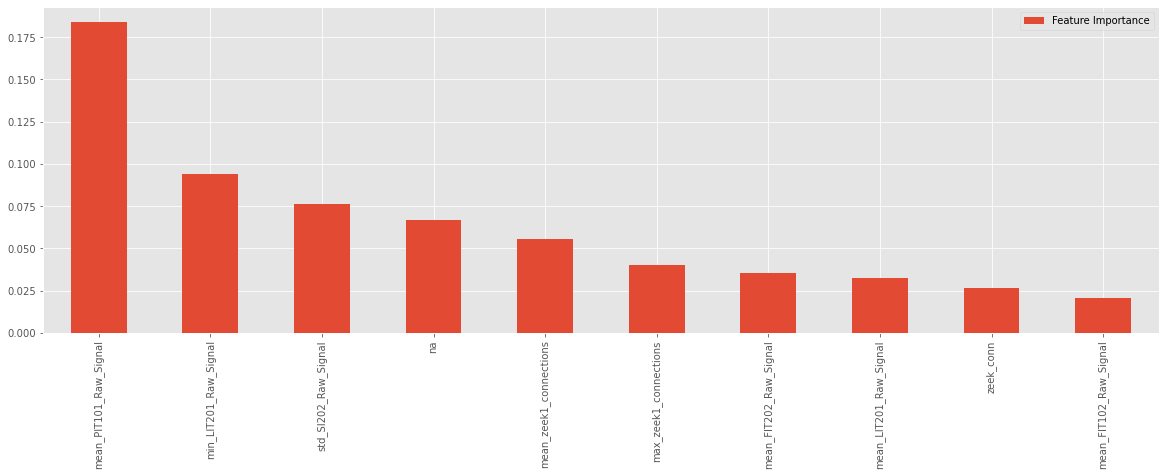

In [22]:
#plot feature importance of xgb
importance_df=pd.DataFrame(xgb_cv3.best_estimator_.feature_importances_, 
                           index=X_train.columns, columns=["Feature Importance"])

importance_df.sort_values(by="Feature Importance", ascending=False).head(10).plot(kind="bar",figsize=(20,6));

In [23]:
#print classification report
from sklearn.metrics import classification_report, plot_confusion_matrix
print('Classification report')
print(classification_report(y_test, y_hat3))
print('\n')

Classification report
              precision    recall  f1-score   support

           0       1.00      0.30      0.47        46
           1       0.78      0.78      0.78       413
           2       0.90      0.92      0.91      1091

    accuracy                           0.87      1550
   macro avg       0.89      0.67      0.72      1550
weighted avg       0.87      0.87      0.86      1550





In [24]:
data_test.event.value_counts()

normal                    1091
HV_201                     234
LCV_103                     44
SV_201                      42
SV_101                      38
LCV_203                     33
dos                         30
injection                   16
power                       10
overall_instrument_air       6
Pumps                        6
Name: event, dtype: int64

In [25]:
data_test.EncodedErrors.value_counts()

2    1091
1     413
0      46
Name: EncodedErrors, dtype: int64